# 02 Continuing the Introduction


For a simpler introduction to `pycox` see the [01_introduction.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) instead.

In this notebook we will show some more functionality of the `pycox` package in addition to more functionality of the `torchtuples` package.
We will continue with the `LogisticHazard` method for simplicity.

We will in the following: 
- use SUPPORT as an example dataset,
- use entity embeddings for categorical variables,
- use the [AdamWR optimizer](https://arxiv.org/pdf/1711.05101.pdf) with cyclical learning rates,
- use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import support
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(123456)
_ = torch.manual_seed(123456)

## Dataset

We load the SUPPORT data set and split in train, test and validation.

In [3]:
df_train = support.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,30.0,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,1527.0,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,7.0,1
5,49.932980,0.0,1.0,1.0,0.0,0.0,0.0,70.0,105.0,33.0,38.195309,127.0,5.299805,1.199951,50.0,1
6,62.942989,0.0,5.0,2.0,1.0,0.0,1.0,116.0,130.0,35.0,38.195309,133.0,14.099609,0.799927,381.0,0


## Feature transforms
We have 14 covariates, in addition to the durations and event indicators.

We will standardize the 8 numerical covariates, and leave the 3 binary variables unaltered. 

We will use entity embedding for the 3 categorical variables `x2`, `x3`, and `x6`.
Hence, they are transformed to `int64` integers representing the categories. The category 0 is reserved for `None` and very small categories that are set to `None`. 
We use the `OrderedCategoricalLong` transform to achieve this.

In [5]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [6]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [7]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

In the `x_fit_transform` and `x_transform` we have wrapped the results with `tt.tuplefy`. The result is a `TupleTree` which equivalent to a regular `tuple`, but with some added functionality that makes it easier to investigate the data.

From the code below we see that `x_train` is a `tuple` with two arrays representing the transformed numerical and categorical covariates.

In [8]:
x_train.types()

(numpy.ndarray, numpy.ndarray)

In [9]:
x_train.shapes()

((5678, 11), (5678, 3))

In [10]:
x_train.dtypes()

(dtype('float32'), dtype('int64'))

## Label transforms

`LogisticHazard` is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of the discretization grid, but we will now let the **quantiles** of the estimated event-time distribution define the grid, as explained in [this paper](https://arxiv.org/abs/1910.06724).

In [11]:
num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)

Note that the discretization grid is far from equidistant. The idea behind the quantile discretization is that the grid is finer where there are many events and coarser where there are few.

In [12]:
labtrans.cuts

array([   0.,    3.,    5.,    8.,   11.,   16.,   22.,   30.,   43.,
         64.,   92.,  129.,  192.,  256.,  368.,  522.,  739., 1005.,
       1348., 2029.], dtype=float32)

We can visualize the grid together with the Kaplan-Meier estaimtes to see this clearly. 

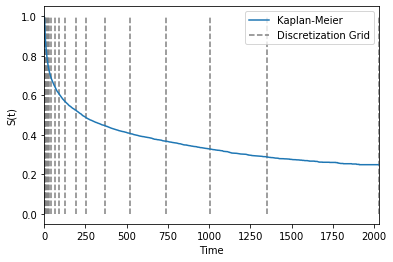

In [13]:
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='gray', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

## Investigating the data

Next we collect the training and validation data with `tt.tuplefy` in a nested tuple to make it simpler to inspect them

In [14]:
train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

In [15]:
train.types()

((numpy.ndarray, numpy.ndarray), (numpy.ndarray, numpy.ndarray))

In [16]:
train.shapes()

(((5678, 11), (5678, 3)), ((5678,), (5678,)))

In [17]:
train.dtypes()

((dtype('float32'), dtype('int64')), (dtype('int64'), dtype('float32')))

We can now alternatively transform the data to torch tensors with `to_tensor`. This is not useful for this notebook, but can be very handy for development.

In [18]:
train_tensor = train.to_tensor()

In [19]:
train_tensor.types()

((torch.Tensor, torch.Tensor), (torch.Tensor, torch.Tensor))

In [20]:
train_tensor.shapes()

((torch.Size([5678, 11]), torch.Size([5678, 3])),
 (torch.Size([5678]), torch.Size([5678])))

In [21]:
train_tensor.dtypes()

((torch.float32, torch.int64), (torch.int64, torch.float32))

In [22]:
del train_tensor

## Neural net

We want our network to take two input arguments, one for the numerical covariates and one for the categorical covariates such that we can apply entity embedding.

The `tt.practical.MixedInputMLP` does exactly this for us. If first applies entity embeddings to the categorical covariates and then concatenate the embeddings with the numerical covariates.

First we need to define the embedding sizes. Here we will let the embedding dimensions be half the size of the number of categories.
This means that each category is represented by a vector that is half the size of the number of categories.

In [23]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [24]:
num_embeddings, embedding_dims

(array([8, 7, 4]), array([4, 3, 2]))

We then define a net with four hidden layers, each of size 32, and include batch normalization and dropout between each layer.

In [25]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [26]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(8, 4)
      (1): Embedding(7, 3)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

## Fitting model

We want to use the cyclic [AdamWR optimizer](https://arxiv.org/abs/1711.05101) where we multiply the learning rate with 0.8 and double then cycle length after every cycle.
Also, we add [decoupled weight decay](https://arxiv.org/abs/1711.05101) for regularization.

In [27]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)

We can use `lr_finder` to find a suitable initial learning rate
with the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf).
See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

The `tolerance` argument just defines the largest loss allowed before terminating the procedure. Is serves mostly a visual purpose.

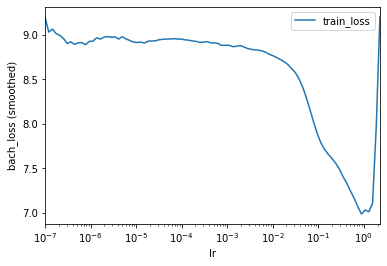

In [28]:
batch_size = 256
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

We can see that this sets the optimizer learning rate in our model to the same value as that of `get_best_lr`.

In [29]:
model.optimizer.param_groups[0]['lr']

0.08902150854450441

In [30]:
lrfind.get_best_lr()

0.08902150854450441

However, we have found that `get_best_lr` sometimes gives a little high learning rate, so  we instead set it to

In [31]:
model.optimizer.set_lr(0.02)

For early stopping, we will use `EarlyStoppingCycle` which work in the same manner as `EarlyStopping` but will stop at the end of **the cycle** if the current best model was not obtained in the current cycle.

In [32]:
epochs = 512
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = False # set to True if you want printout

In [33]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

CPU times: user 47.1 s, sys: 1.74 s, total: 48.9 s
Wall time: 23.3 s


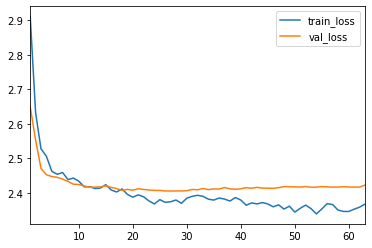

In [34]:
_ = log.to_pandas().iloc[1:].plot()

We can now plot the learning rates used through the training with following piece of code

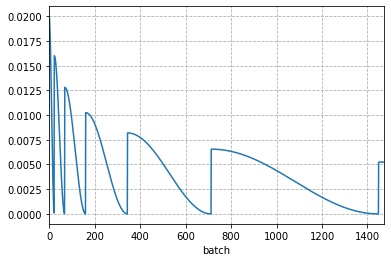

In [35]:
lrs = model.optimizer.lr_scheduler.to_pandas() * model.optimizer.param_groups[0]['initial_lr']
lrs.plot()
plt.grid(linestyle='--')

## Evaluation

The `LogisticHazard` method has two implemented interpolation schemes: the constant density interpolation (default) and constant hazard interpolation. See [this paper](https://arxiv.org/abs/1910.06724) for details.

In [36]:
surv_cdi = model.interpolate(100).predict_surv_df(x_test)
surv_chi = model.interpolate(100, 'const_hazard').predict_surv_df(x_test)

In [37]:
ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
ev_chi = EvalSurv(surv_chi, durations_test, events_test, censor_surv='km')

In [38]:
ev_cdi.concordance_td(), ev_chi.concordance_td()

(0.6305366659876536, 0.630559781328872)

In [39]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev_cdi.integrated_brier_score(time_grid), ev_chi.integrated_brier_score(time_grid)

(0.19502317626753513, 0.20115977074187133)

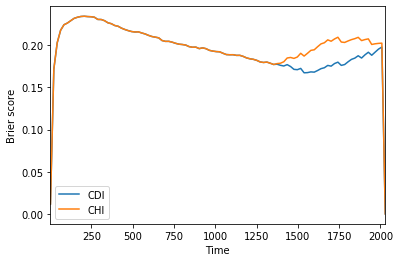

In [40]:
ev_cdi.brier_score(time_grid).rename('CDI').plot()
ev_chi.brier_score(time_grid).rename('CHI').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

We see from the figures that, in this case, the constant hazard interpolated estimates are not as good as the constant density interpolated estimates.

## Investigate what's going on

The instabilities at the end of the plot above is a consequence for our discretization scheme.

From `labtrans` we can get the last two discretization points

In [41]:
labtrans.cuts[-2:]

array([1348., 2029.], dtype=float32)

Now, because the censoring times in this interval are rounded down while events times are rounded up, we get an unnatural proportion of events at the final time point.

In [42]:
data = train.iloc[train[1][0] == train[1][0].max()]
data[1][1]

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

We see the almost all training individuals here have an event!

In [43]:
data[1][1].mean()

0.93939394

While the true event proportion of individuals that survival past 1500 is almost zero

In [44]:
df_train.loc[lambda x: x['duration'] > 1500]['event'].mean()

0.061224489795918366

This is one of the dangers with discretization, and one should take caution. The simple solution would be to ensure that there are more discretization point in this interval, or simply not evaluate past the time 1348.

If we take a look at individuals in the test set that are censored some time after 1500, we see that the survival estimates are not very appropriate.

In [45]:
test = tt.tuplefy(x_test, (durations_test, events_test))
data = test.iloc[(durations_test > 1500) & (events_test == 0)]
n = data[0][0].shape[0]

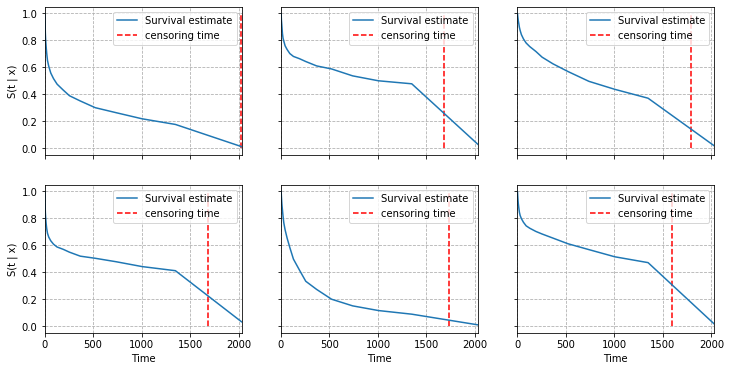

In [46]:
idx = np.random.choice(n, 6)
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
for i, ax in zip(idx, axs.flat):
    x, (t, _) = data.iloc[[i]]
    surv = model.predict_surv_df(x)
    surv[0].rename('Survival estimate').plot(ax=ax)
    ax.vlines(t, 0, 1, colors='red', linestyles="--",
               label='censoring time')
    ax.grid(linestyle='--')
    ax.legend()
    ax.set_ylabel('S(t | x)')
    _ = ax.set_xlabel('Time')

# Next

You can now look at other examples of survival methods in the [examples folder](https://nbviewer.jupyter.org/github/havakv/pycox/tree/master/examples).
Or, alternatively take a look at

- other network architectures that combine autoencoders and survival networks in the notebook [03_network_architectures.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/03_network_architectures.ipynb).
- working with DataLoaders and convolutional networks in the notebook [04_mnist_dataloaders_cnn.ipynb](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/04_mnist_dataloaders_cnn.ipynb).